In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import statsmodels.api as sm 
import scipy.stats as stats

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score




In [7]:
# data loading
df_gold = pd.read_csv('LBMA-GOLD.csv')
df_bchain = pd.read_csv('BCHAIN-MKPRU.csv')
# turn to timestamp
df_gold['Date'] = pd.to_datetime(df_gold['Date'],format='mixed')
df_bchain['Date'] = pd.to_datetime(df_bchain['Date'],format='mixed')
df_gold = df_gold.set_index('Date')
df_bchain = df_bchain.set_index('Date')
# fill in the weekend data with forward value
full_range_gold = pd.date_range(start=df_gold.index.min(), end=df_gold.index.max(), freq='D')
full_range_bchain = pd.date_range(start=df_bchain.index.min(), end=df_bchain.index.max(), freq='D')
df_gold_fill = df_gold.reindex(full_range_gold, method='ffill')
df_bchain_fill = df_bchain.reindex(full_range_bchain, method='ffill')
# separate into training set and test set based on the time
df_train_gold = df_gold_fill[df_gold_fill.index< '2021-08-10']
df_train_bchain = df_bchain_fill[df_bchain_fill.index < '2021-08-10']
df_test_gold = df_gold_fill[df_gold_fill.index >= '2021-08-10']
df_test_bchain = df_bchain_fill[df_bchain_fill.index >= '2021-08-10']


**GOLD**:

This part is the ARIMA implementation for GOLD price

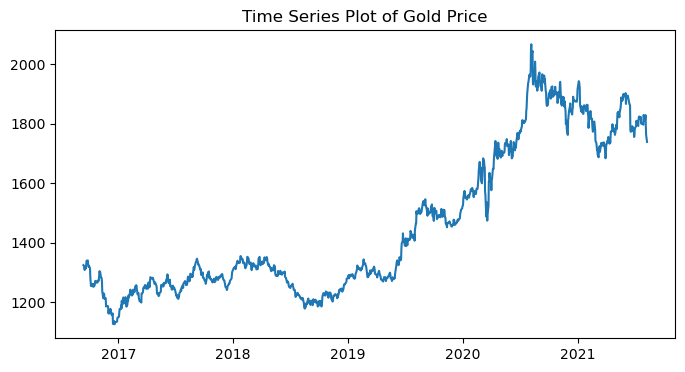

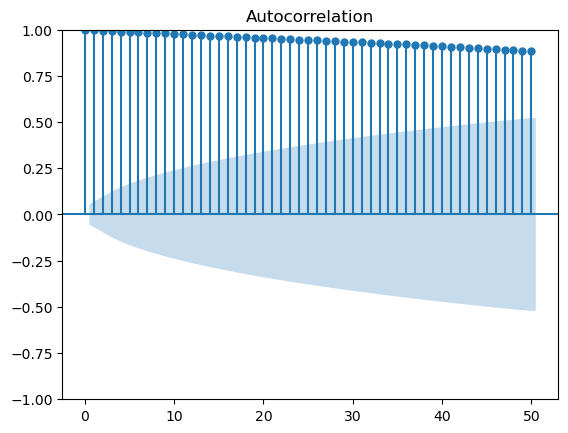

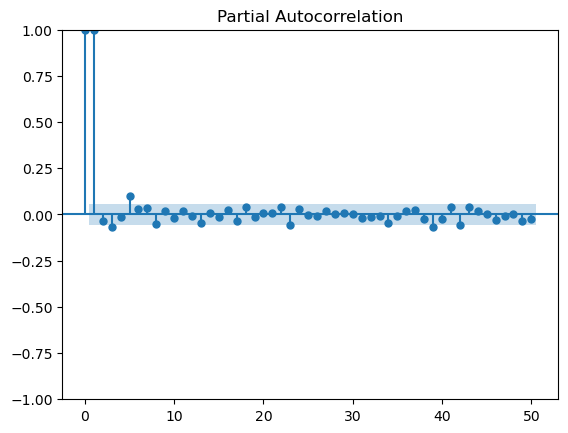

In [66]:
# plot the time-series plot, ACF and PACF
plt.figure(figsize = (8,4))
plt.plot(df_train_gold['Date'],df_train_gold['USD (PM)'])
plt.title('Time Series Plot of Gold Price')
plt.show()

plot_acf(df_train_gold['USD (PM)'],lags = 50)
plt.show()

plot_pacf(df_train_gold['USD (PM)'],lags = 50)
plt.show()


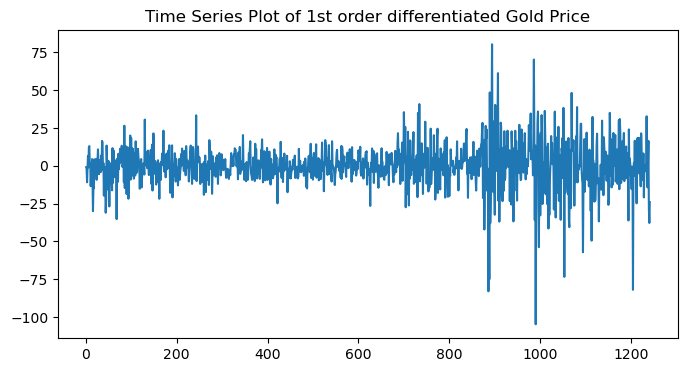

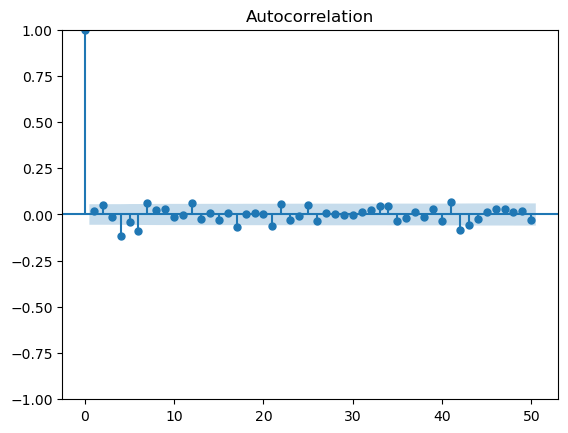

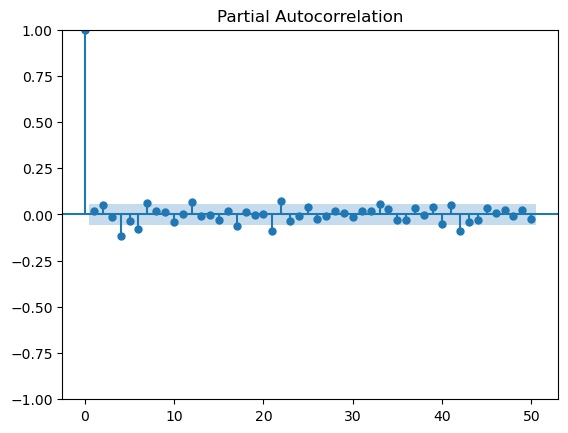

In [68]:
# Plot the time-series plot, ACF and PCAF for the data after 1st order difference
df_gold_first = df_train_gold.diff(1).dropna()
plt.figure(figsize = (8,4))
df_gold_first['USD (PM)'].plot(title='Time Series Plot of 1st order differentiated Gold Price')
plt.show()

plot_acf(df_gold_first['USD (PM)'],lags = 50)
plt.show()

plot_pacf(df_gold_first['USD (PM)'],lags = 50)
plt.show()

Does not have obvious seasonality pattern - fit with ARIMA model

**Modelling**

In [587]:
model = pm.auto_arima(df_train_gold['USD (PM)'], seasonal=False,  
                   trace=True, error_action='ignore', suppress_warnings=True)

df_gold_arima = df_train_gold.copy()
new_dates = pd.date_range(start=df_gold_arima.index[-1] + pd.Timedelta(days=1), periods=32, freq='D')
new_values = df_test_gold['USD (PM)']
n_period = 2

weekly_data = []
forecasts = []
dates = []

# every time we predict the value
# we will use the true data to fine-tune our model for the next prediction
for new_date, new_value in zip(new_dates, new_values):
    # Predict the next value
    weekly_data.append(new_value)
    dates.append(new_date)

    if len(dates) == n_period or new_date == new_dates[-1]:
        next_day_forecast = model.predict(n_periods=n_period)
        forecasts += list(next_day_forecast)
        model.update(pd.Series(weekly_data, index = dates))
        weekly_data = []
        dates = []

forecasts = forecasts[0:32]


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13826.483, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13837.125, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13838.174, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13838.214, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13835.852, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13840.321, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13840.578, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13827.818, Time=0.88 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13843.055, Time=1.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13839.908, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13840.768, Time=0.56 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13841.573, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=13827.893, Time=0.97 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=13825.184, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0

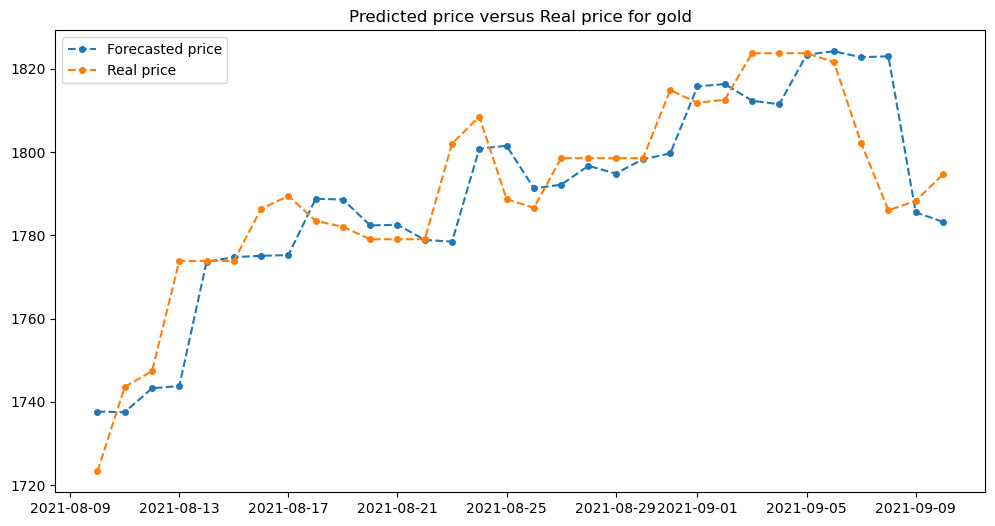

In [588]:
#plot the figs of forecasted price and real price
plt.figure(figsize=(12,6))
plt.plot(new_dates,forecasts,label = 'Forecasted price',linestyle = '--',marker = 'o',markersize = 4)
plt.plot(new_dates,new_values,label = 'Real price',linestyle = '--',marker = 'o',markersize = 4)
plt.title('Predicted price versus Real price for gold')
plt.legend()

In [595]:
# evaluation
mae = mean_absolute_error(new_values, forecasts)
print(f'mean absolute error: {mae}')

mse = mean_squared_error(new_values, forecasts)
print(f'mean square error: {mse}')
print(f'root mean suqare error: {np.sqrt(mse)}')

r_squared = r2_score(new_values, forecasts)
print(f'r2 score: {r_squared}')


mean absolute error: 8.804971990885868
mean square error: 153.5347925632999
root mean suqare error: 12.39091572739077
r2 score: 0.7048154444695012


Text(0.5, 1.0, 'Autocorrelation of Residuals')

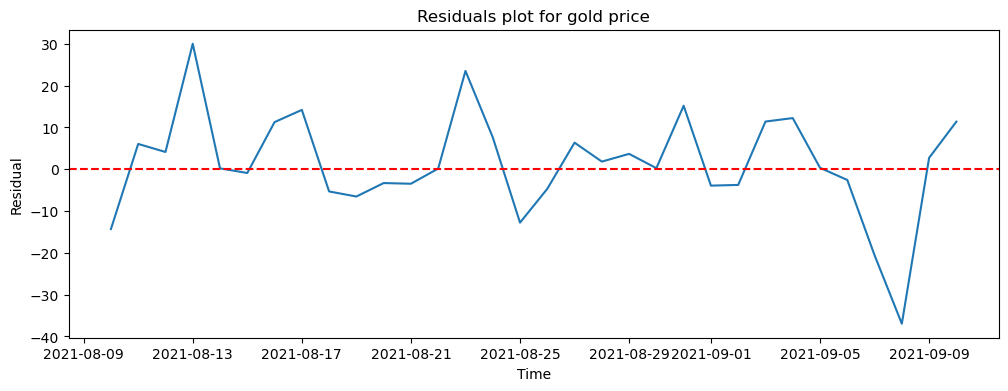

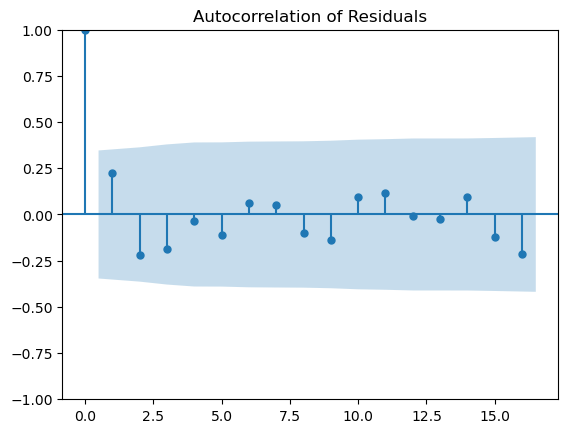

In [596]:
# check the stationarity of residuals
residuals_gold = new_values - forecasts
plt.figure(figsize=(12, 4))
plt.plot(residuals_gold)
plt.title('Residuals plot for gold price')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.axhline(y=0, color='r', linestyle='--')

plot_acf(residuals_gold)
plt.title('Autocorrelation of Residuals')



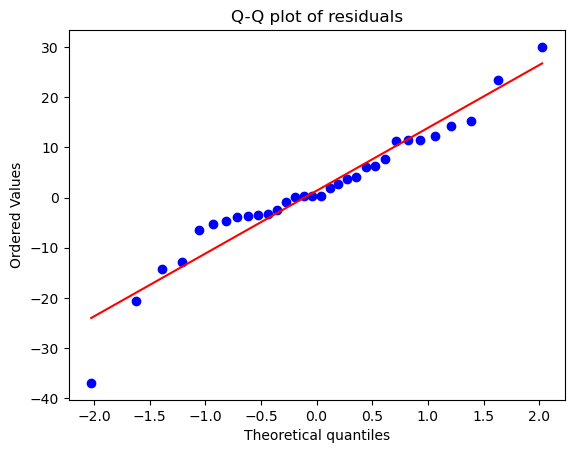

,lb_stat,lb_pvalue
10,7.445887,0.682786


In [592]:
#check the qq-plot
stats.probplot(residuals_gold, dist="norm", plot=plt)
plt.title('Q-Q plot of residuals')
plt.show()

acorr_ljungbox(residuals_gold, lags=[10], return_df=False)


In [597]:
# turn into csv file for following process
dict_gold = pd.DataFrame({'Date':list(new_dates),'USD (PM)':new_values},index=None)
dict_gold.to_csv('gold_forecast_output.csv', index=False)


**Bchain**

In [16]:
# rough data exploration
df_train_bchain_log = df_train_bchain.copy()
df_train_bchain_log['Value'] = np.log(df_train_bchain_log['Value'])

print(df_train_bchain['Value'].min())
print(df_train_bchain['Value'].median())
print(df_train_bchain['Value'].mean())
print(df_train_bchain['Value'].max())
print(df_train_bchain['Value'].std())

594.08
7788.35
11571.067933088796
63554.44
13328.950952108276


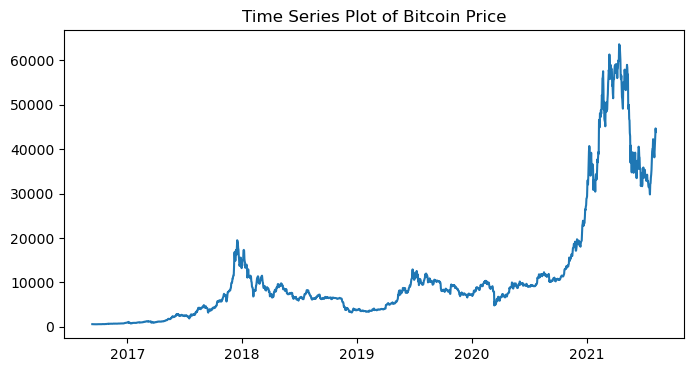

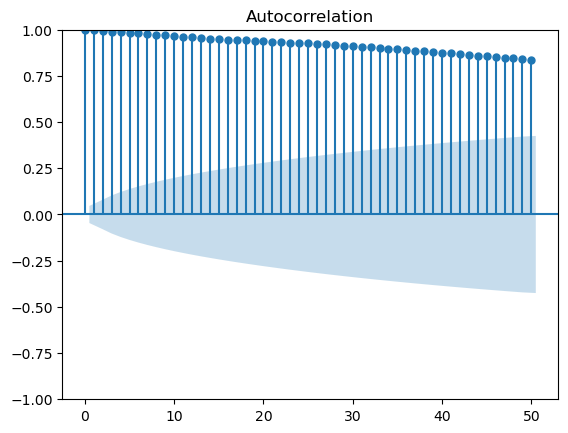

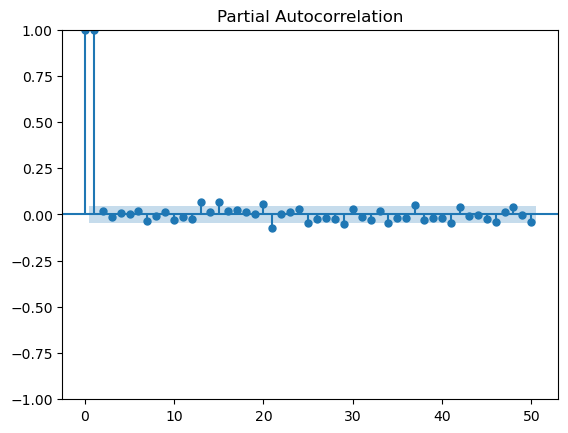

In [17]:
plt.figure(figsize = (8,4))
plt.plot(df_train_bchain['Value'])
plt.title('Time Series Plot of Bitcoin Price')
plt.show()

plot_acf(df_train_bchain['Value'],lags = 50)
plt.show()

plot_pacf(df_train_bchain['Value'],lags = 50)
plt.show()

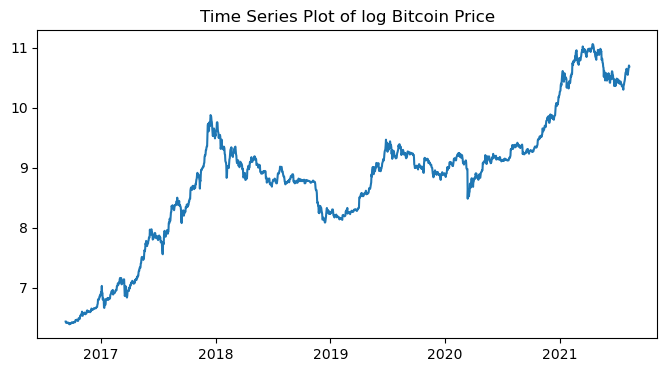

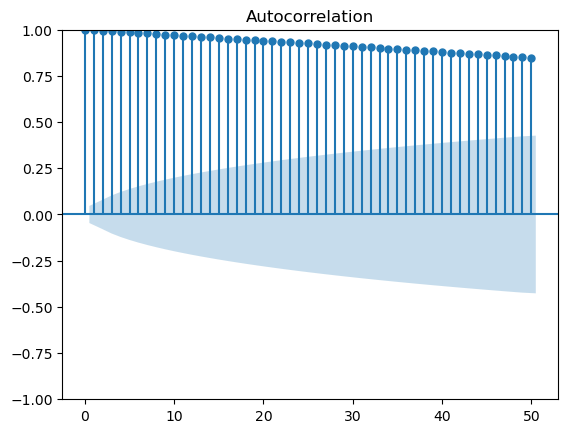

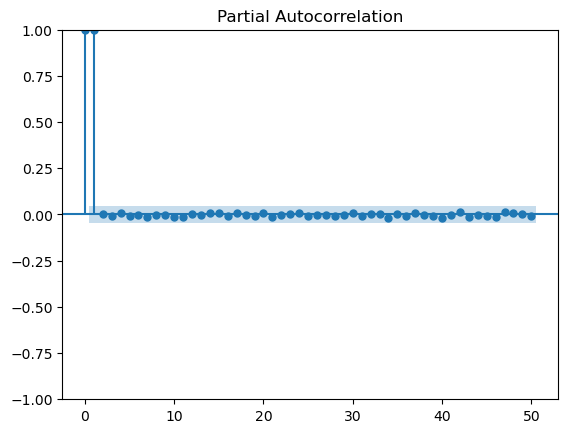

In [5]:
# take logrithm and see the time-series, acf and pacf performance
plt.figure(figsize = (8,4))
plt.plot(df_train_bchain_log['Value'])
plt.title('Time Series Plot of log Bitcoin Price')
plt.show()

plot_acf(df_train_bchain_log['Value'],lags = 50)
plt.show()

plot_pacf(df_train_bchain_log['Value'],lags = 50)
plt.show()


<Figure size 800x400 with 0 Axes>

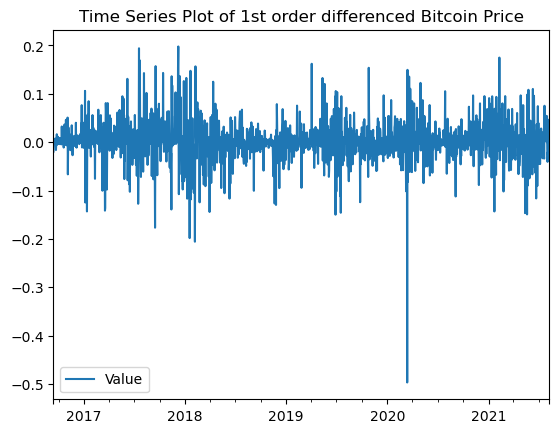

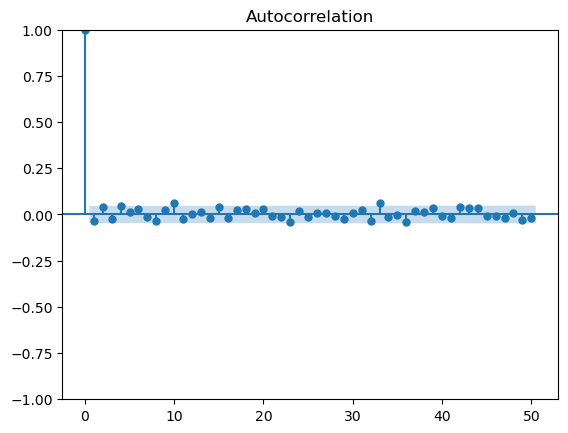

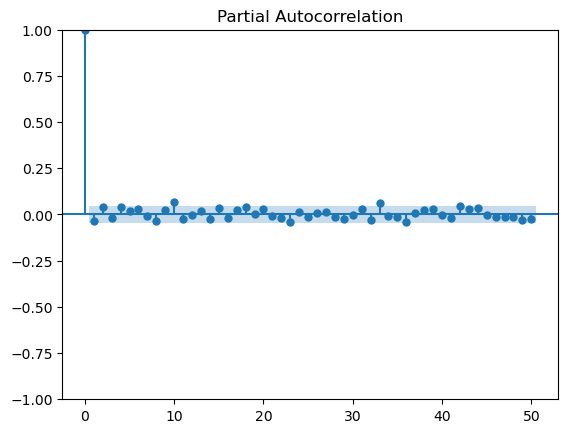

(-12.128182623997862, 1.7607660146327053e-22, 9, 1783, {'1%': -3.434022876868246, '5%': -2.8631623708604996, '10%': -2.5676336990659903}, -6165.810210810406)


In [8]:
# check the stationarity after first order difference
df_bchain_first_log = df_train_bchain_log.diff(1).dropna()
plt.figure(figsize = (8,4))
df_bchain_first_log.plot(title='Time Series Plot of 1st order differenced Bitcoin Price')
plt.show()

plot_acf(df_bchain_first_log,lags = 50)
plt.show()

plot_pacf(df_bchain_first_log,lags = 50)
plt.show()

print(adfuller(df_bchain_first_log))


There is no seasonality pattern - fit with ARIMA model

**Modelling:**

In [12]:
model_bchain = pm.auto_arima(df_train_bchain_log['Value'], seasonal=False,  # m is the seasonal period
                   trace=True, error_action='ignore', suppress_warnings=True)

df_bchain_arima = df_train_bchain_log.copy()
new_dates = pd.date_range(start=df_bchain_arima.index[-1] + pd.Timedelta(days=1), periods=32, freq='D')
new_dates_bchain = pd.date_range(start=df_bchain_arima.index[-1] + pd.Timedelta(days=1), periods=32, freq='D')
new_values_bchain = np.log(df_test_bchain['Value'])
n_period = 3

weekly_data = []
forecasts = []
dates = []
forecasts_bchain = []
for new_date, new_value in zip(new_dates_bchain, new_values_bchain):
    weekly_data.append(new_value)
    dates.append(new_date)

    # Update the model with the actual value
    if len(dates) == n_period or new_date == new_dates[-1]:
        next_day_forecast = model_bchain.predict(n_periods=n_period)
        forecasts_bchain += list(next_day_forecast)
        model_bchain.update(pd.Series(weekly_data, index=dates))
        weekly_data = []
        dates = []

forecasts_bchain = forecasts_bchain[0:32]


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6277.445, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6277.347, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6277.659, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6277.488, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6273.625, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6278.524, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6277.309, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6278.492, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6280.460, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6278.834, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6278.091, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6276.471, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.107 seconds


mean absolute error: 1489.8958440073438
mean square error: 3241552.3445734926
root mean absolute error: 1800.4311551885266
r2 score: 0.15035058464062


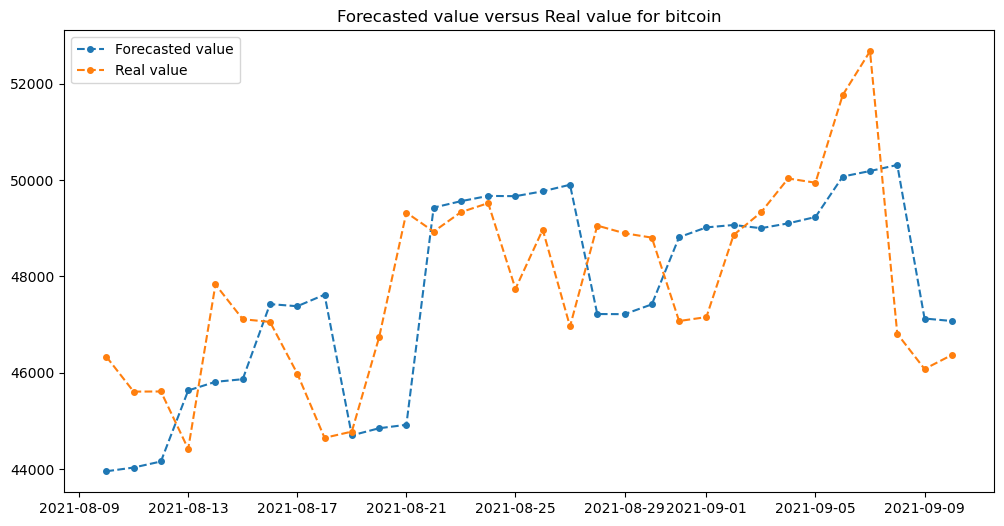

In [13]:
#plot the predicted value with the real value and make a comparison
plt.figure(figsize=(12,6))
plt.plot(new_dates_bchain,np.exp(forecasts_bchain),label = 'Forecasted value',linestyle = '--',marker = 'o',markersize = 4)
plt.plot(new_dates_bchain,np.exp(new_values_bchain),label = 'Real value',linestyle = '--',marker = 'o',markersize = 4)
plt.legend()
plt.title('Forecasted value versus Real value for bitcoin')

mae = mean_absolute_error(np.exp(new_values_bchain), np.exp(forecasts_bchain))
print(f'mean absolute error: {mae}')

mse = mean_squared_error(np.exp(new_values_bchain), np.exp(forecasts_bchain))
print(f'mean square error: {mse}')
print(f'root mean absolute error: {np.sqrt(mse)}')

r_squared = r2_score(np.exp(new_values_bchain), np.exp(forecasts_bchain))
print(f'r2 score: {r_squared}')


Text(0.5, 1.0, 'Autocorrelation of Residuals')

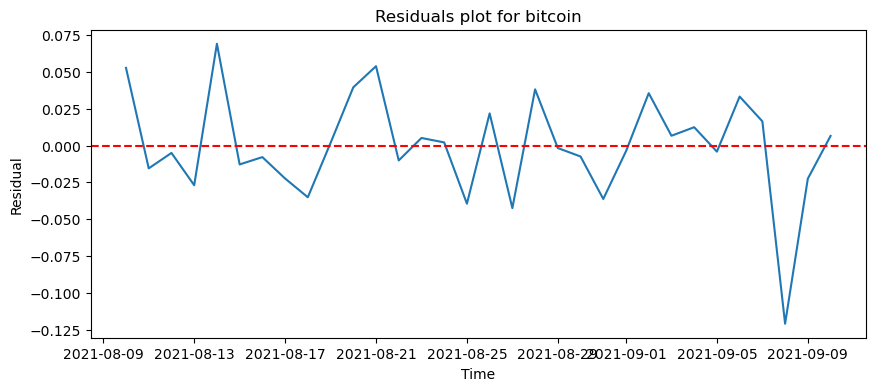

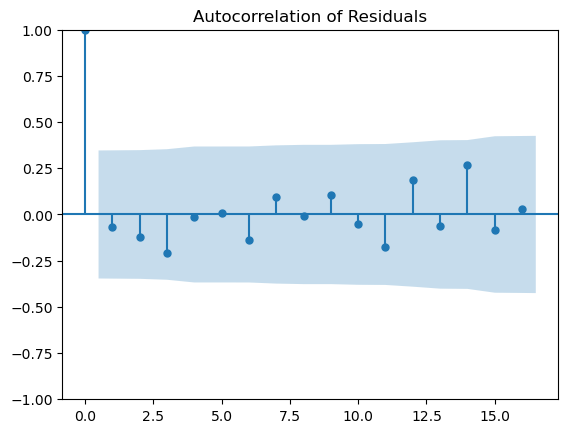

In [489]:
#check the stationarity of residuals
residuals_bchain = new_values_bchain - forecasts_bchain
plt.figure(figsize=(10, 4))
plt.plot(residuals_bchain)
plt.title('Residuals plot for bitcoin')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.axhline(y=0, color='r', linestyle='--')

plot_acf(residuals_bchain)
plt.title('Autocorrelation of Residuals')




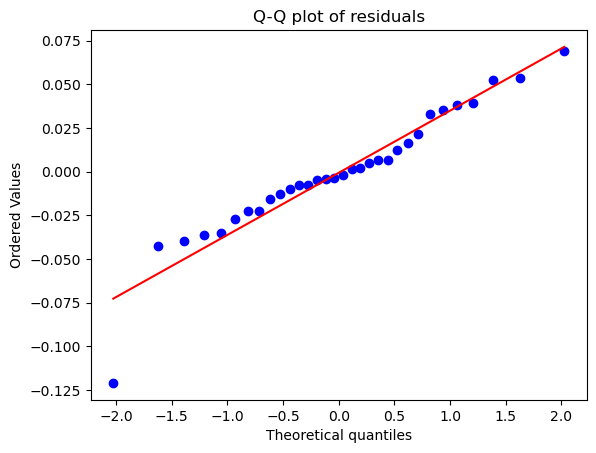

,lb_stat,lb_pvalue
10,4.211258,0.937314


In [616]:
# Check the qq-plot
stats.probplot(residuals_bchain, dist="norm", plot=plt)
plt.title('Q-Q plot of residuals')
plt.show()

acorr_ljungbox(residuals_bchain, lags=[10], return_df=False)

In [14]:
#turn it into csv for further process
dict_bchain = pd.DataFrame({'Date':list(new_dates_bchain),'USD (PM)':np.exp(new_values_bchain)},index=None)
dict_bchain.to_csv('bchain_forecast_output.csv', index=False)